In [1]:
import numpy as np
import torch
import os
import net
import utils
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image, make_grid
from time import time
import pickle
import random
from pathlib import Path

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [2]:
BATCH_SIZE = 32
DS_FOLDER = "/home/ML_courses/03683533_2021/dataset"
LR = 1e-4
DEVICE_ID = 0
VAL_RANGE = 1000
TRAIN_RANGE = None
NUM_WORKERS = 16
NUM_EPOCHS = 20
SHUFFLE = False
RUN_NAME = 'baseline_noBN'

# Network and optimizer

In [3]:
model = net.AutoEncoder()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
device = f'cuda:{DEVICE_ID}' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

cuda:0


AutoEncoder(
  (activation): LeakyReLU(negative_slope=0.01)
  (last_activation): Sigmoid()
  (enc1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (enc1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc5): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc5_bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_runni

# Data Loader & Dataset

In [4]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.ToTensor(),
                                ])

class UniDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        x = Image.open(image_path)
        if self.transform is not None:
            x = self.transform(x)
        return x
    
    def __len__(self):
        return len(self.image_paths)

In [5]:
val_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[:VAL_RANGE]]
if TRAIN_RANGE != None:
    train_files = [os.path.join(DS_FOLDER,i) for i in 
                   sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:TRAIN_RANGE+1+VAL_RANGE]]
else:
    train_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:]]

In [6]:
val_ds = UniDataset(val_files, transform=transform)
train_ds = UniDataset(train_files, transform=transform)

In [7]:
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True, shuffle=SHUFFLE)

# Train model

In [8]:
def save_imgs(true_imgs, val_imgs, dirname, epoch):
    path = os.path.join('results', RUN_NAME, epoch)
    os.makedirs(path, exist_ok=True)
    save_image(val_imgs, os.path.join(path, 'val_pred.png'))
    save_image(true_imgs, os.path.join(path, 'val_true.png'))

In [9]:
def calc_val_loss(val_dl, epoch, dirname):
    with torch.no_grad():
        val_loss = 0.0
        for images in val_dl:
            images = images.float().to(device)
            outputs = model(images)
            images.require_grad = False
            loss = criterion(outputs, images)
            val_loss += loss.item()
    images = images.cpu()
    outputs = outputs.view(outputs.size(0), 3, 256, 256).cpu().data
    save_imgs(images, outputs, dirname, epoch)
    return val_loss/len(val_dl), make_grid(images), make_grid(outputs)

In [10]:
%%time

train_losses = {}
val_losses = {}
for epoch in range(1, NUM_EPOCHS+1):
    t = time()
    train_loss = 0.0
    for images in tqdm(train_dl):
        images = images.float()
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    val_loss, val_true_grid, val_pred_grid = calc_val_loss(val_dl, str(epoch), RUN_NAME)
    train_loss = train_loss/len(train_dl)
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    print('Epoch: {} \tTraining Loss: {:.6f} \tVal Loss: {:.6f}\t \
    in time {:2f}m'.format(epoch, train_loss, val_loss, (time()-t)/60))


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:49<00:00, 11.13it/s]


Epoch: 1 	Training Loss: 0.585335 	Val Loss: 0.550224	     in time 1.860475m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:56<00:00, 10.46it/s]


Epoch: 2 	Training Loss: 0.548092 	Val Loss: 0.543525	     in time 1.980905m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:57<00:00, 10.40it/s]


Epoch: 3 	Training Loss: 0.544021 	Val Loss: 0.540789	     in time 1.992053m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:57<00:00, 10.37it/s]


Epoch: 4 	Training Loss: 0.541929 	Val Loss: 0.539027	     in time 1.997873m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:57<00:00, 10.39it/s]


Epoch: 5 	Training Loss: 0.540242 	Val Loss: 0.537254	     in time 1.994694m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:57<00:00, 10.41it/s]


Epoch: 6 	Training Loss: 0.538626 	Val Loss: 0.535844	     in time 1.989018m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:56<00:00, 10.42it/s]


Epoch: 7 	Training Loss: 0.537299 	Val Loss: 0.534649	     in time 1.987926m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:56<00:00, 10.43it/s]


Epoch: 8 	Training Loss: 0.536267 	Val Loss: 0.533766	     in time 1.986969m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:57<00:00, 10.41it/s]


Epoch: 9 	Training Loss: 0.535547 	Val Loss: 0.533170	     in time 1.990595m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:56<00:00, 10.45it/s]


Epoch: 10 	Training Loss: 0.535022 	Val Loss: 0.532691	     in time 1.982528m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:57<00:00, 10.40it/s]


Epoch: 11 	Training Loss: 0.534607 	Val Loss: 0.532341	     in time 1.993564m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:57<00:00, 10.40it/s]


Epoch: 12 	Training Loss: 0.534289 	Val Loss: 0.532048	     in time 1.991355m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:57<00:00, 10.38it/s]


Epoch: 13 	Training Loss: 0.534027 	Val Loss: 0.531798	     in time 1.996000m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:57<00:00, 10.41it/s]


Epoch: 14 	Training Loss: 0.533791 	Val Loss: 0.531569	     in time 1.990079m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:57<00:00, 10.39it/s]


Epoch: 15 	Training Loss: 0.533550 	Val Loss: 0.531338	     in time 1.994450m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:57<00:00, 10.40it/s]


Epoch: 16 	Training Loss: 0.533330 	Val Loss: 0.531132	     in time 1.991031m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:57<00:00, 10.42it/s]


Epoch: 17 	Training Loss: 0.533110 	Val Loss: 0.530911	     in time 1.988940m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:57<00:00, 10.42it/s]


Epoch: 18 	Training Loss: 0.532873 	Val Loss: 0.530649	     in time 1.987963m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:57<00:00, 10.39it/s]


Epoch: 19 	Training Loss: 0.532600 	Val Loss: 0.530346	     in time 1.993121m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:57<00:00, 10.39it/s]


Epoch: 20 	Training Loss: 0.532259 	Val Loss: 0.529974	     in time 1.994012m
CPU times: user 32min 3s, sys: 10min 54s, total: 42min 57s
Wall time: 39min 41s


# Results

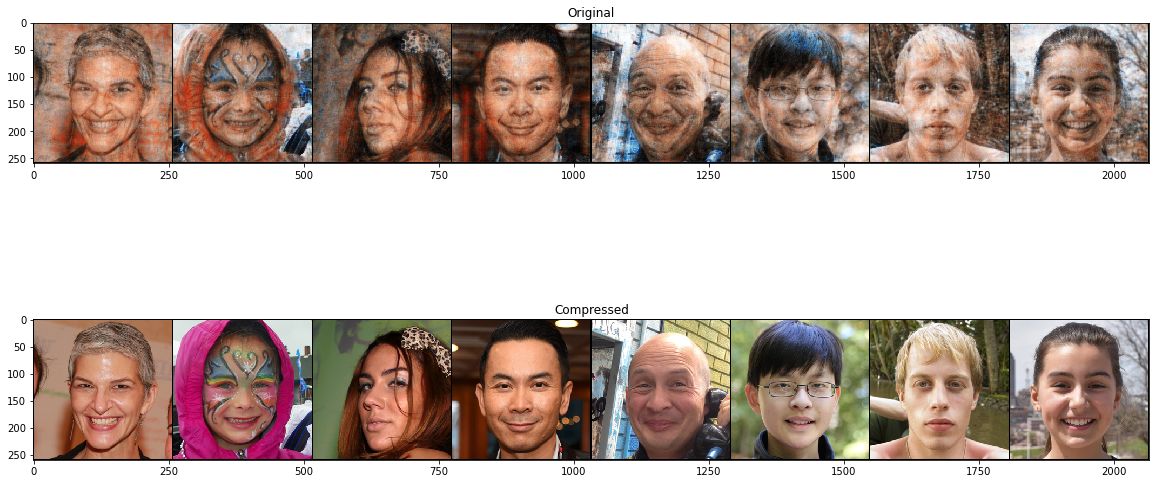

In [11]:
utils.show(val_true_grid, val_pred_grid)

In [12]:
path = Path("results") / RUN_NAME

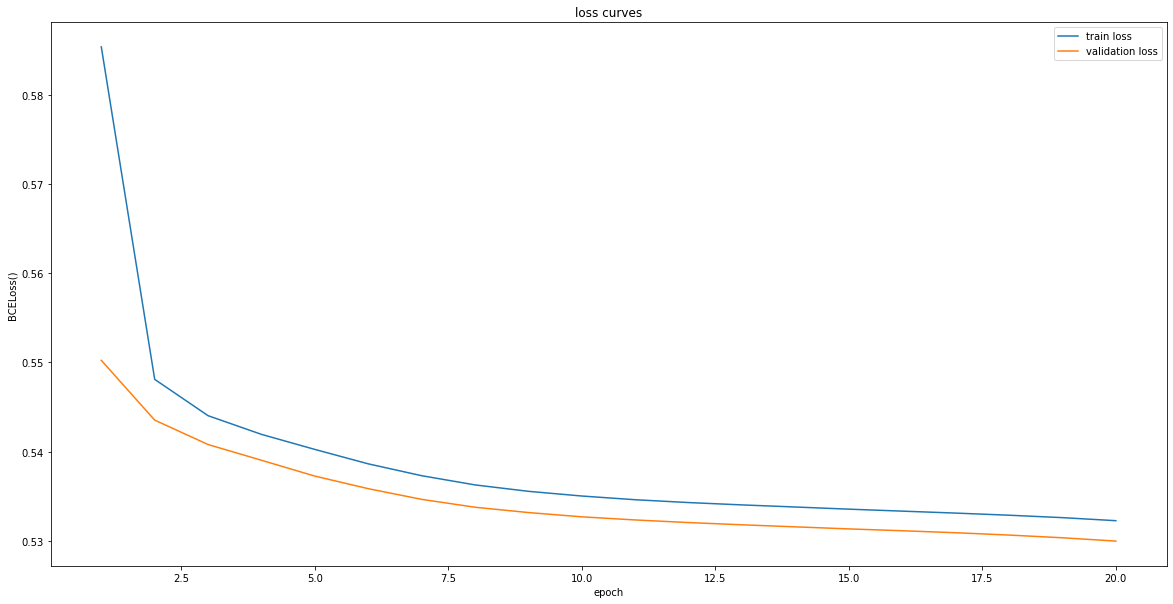

In [13]:
utils.plot_loss(criterion, train_losses, val_losses, path)

In [14]:
utils.write_losses(path, train_losses, val_losses)

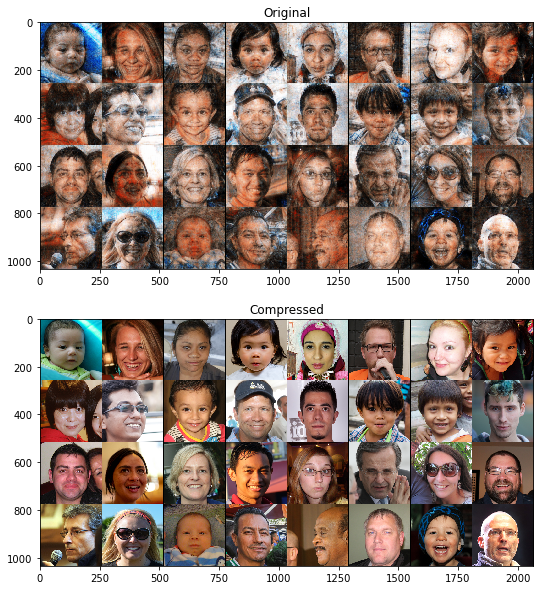

In [15]:
images = list(val_dl)[0]
outputs = model(images.to(device)).cpu()
utils.show(make_grid(images), make_grid(outputs), save=True, path=path)